## Config

In [ ]:
import torch

config = {
    "vocab_size": 50257,       # GPT2 tokenizer vocab
    "block_size": 128,         # Max sequence length
    "embedding_dim": 256,
    "num_heads": 4,
    "ffn_dim": 1024,
    "recursion_depth": 3,
    "num_layers": 1,           # Shared block count (usually 1–2)
    "batch_size": 16,
    "lr": 3e-4,
    "num_epochs": 3,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}


## Dataset

In [2]:
!pip install datasets transformers einops matplotlib seaborn --quiet

In [ ]:
from datasets import load_dataset
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have pad token

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
text_data = dataset["train"]["text"]

# Filter short lines and tokenize
cleaned = [line for line in text_data if len(line.strip()) > 20]
joined = " ".join(cleaned)

tokens = tokenizer(joined, return_tensors='pt', truncation=False)["input_ids"][0]
block_size = config["block_size"]

# Split into sequences
sequences = [tokens[i:i+block_size] for i in range(0, len(tokens)-block_size, block_size)]
print(f"Loaded {len(sequences)} sequences of length {block_size}")


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class ToyTextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx][:-1]
        y = self.sequences[idx][1:]
        return x, y

train_dataset = ToyTextDataset(sequences)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)


In [5]:
for x, y in train_loader:
    print(f"Input shape: {x.shape}, Target shape: {y.shape}")
    print("Sample tokens:", x[0][:10])
    print("As text:", tokenizer.decode(x[0][:50]))
    break

Input shape: torch.Size([16, 127]), Target shape: torch.Size([16, 127])
Sample tokens: tensor([15342, 17704,   329, 44000,   366,   262, 40787,  4381,  1022,  6260])
As text:  praised Brooks for illustrating " the tacit agreement between writer and reader that is essential to the success of stories about the end of the world ... [ both ] agree to pretend that this is not fiction , that in fact the horrific tales of a war between humans


## Recursive Block + Routing Head

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RecursiveTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config["embedding_dim"])
        self.attn = nn.MultiheadAttention(
            embed_dim=config["embedding_dim"],
            num_heads=config["num_heads"],
            batch_first=True
        )
        self.ln2 = nn.LayerNorm(config["embedding_dim"])
        self.ffn = nn.Sequential(
            nn.Linear(config["embedding_dim"], config["ffn_dim"]),
            nn.GELU(),
            nn.Linear(config["ffn_dim"], config["embedding_dim"])
        )

    def forward(self, x, attn_mask=None, cache_kv=False):
        # Self-attention
        h = self.ln1(x)
        attn_out, _ = self.attn(h, h, h, attn_mask=attn_mask)
        x = x + attn_out

        # Feedforward
        h = self.ln2(x)
        x = x + self.ffn(h)

        if cache_kv: # Cache key/values for MoR
          return x, h
        return x


In [8]:
class RoutingHead(nn.Module):
    """Token choice Routing"""
    def __init__(self, config):
        super().__init__()
        self.recursion_depth = config["recursion_depth"]
        self.linear = nn.Linear(config["embedding_dim"], config["recursion_depth"])

    def forward(self, x):
        """
        x: [batch_size, seq_len, embed_dim]
        returns: [batch_size, seq_len] integer depth values (1 to N_r)
        """
        scores = self.linear(x)  # [B, T, N_r]
        probs = F.softmax(scores, dim=-1)
        depths = torch.argmax(probs, dim=-1) + 1  # Shift to [1, N_r]
        return depths

In [9]:
class MoRModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = nn.Embedding(config["vocab_size"], config["embedding_dim"])
        self.pos_embed = nn.Parameter(torch.zeros(1, config["block_size"], config["embedding_dim"]))
        self.routing_head = RoutingHead(config)

        # Shared transformer block(s)
        self.recursive_blocks = nn.ModuleList([
            RecursiveTransformerBlock(config) for _ in range(config["num_layers"])
        ])

        self.ln_f = nn.LayerNorm(config["embedding_dim"])
        self.lm_head = nn.Linear(config["embedding_dim"], config["vocab_size"], bias=False)

    def forward(self, input_ids):
        B, T = input_ids.size()
        x = self.token_embed(input_ids) + self.pos_embed[:, :T, :]  # [B, T, D]

        routing_depths = self.routing_head(x)  # [B, T], values in [1, N_r]

        # Initialize hidden states
        h = x
        kv_cache = []

        for r in range(1, self.config["recursion_depth"] + 1):
            # Create a mask: which tokens require at least r steps
            active_mask = (routing_depths >= r).unsqueeze(-1)  # [B, T, 1]

            for block in self.recursive_blocks:
                h_new, kv = block(h, cache_kv=True)
                kv_cache.append((kv * active_mask).detach())  # Optional: detach() to save memory
                h = torch.where(active_mask, h_new, h)  # Update only active tokens

        h = self.ln_f(h)
        logits = self.lm_head(h)

        return logits, routing_depths


In [10]:
import torch
from torch import nn, optim
from tqdm import tqdm

# Initialize model
model = MoRModel(config).to(config["device"])
optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
criterion = nn.CrossEntropyLoss()


### Load Pre-trained Model

In [14]:
model.load_state_dict(torch.load(folder+"/base_model.pth", map_location=config['device']))

<All keys matched successfully>

In [12]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
folder = "/content/drive/MyDrive/Implementation/Mixture of Recursions/files/models"

### Training Loop

In [ ]:
all_depths = []
def train(model, dataloader, optimizer, criterion, config):
    model.train()
    for epoch in range(config["num_epochs"]):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        total_loss = 0

        for x, y in pbar:
            x = x.to(config["device"])
            y = y.to(config["device"])

            optimizer.zero_grad()
            logits, depths = model(x)

            # Shift logits and targets for LM training
            logits = logits.view(-1, config["vocab_size"])
            y = y.view(-1)

            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_depths.append(depths.cpu())

            pbar.set_postfix({"loss": loss.item()})

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")
        # print(f"KV Cache Sizes: {[kv.abs().sum().item() for kv in kv_cache]}")


In [ ]:
train(model, train_loader, optimizer, criterion, config)

Epoch 1: 100%|██████████| 1168/1168 [01:27<00:00, 13.37it/s, loss=5.27]


Epoch 1 Avg Loss: 5.6129


Epoch 2: 100%|██████████| 1168/1168 [01:27<00:00, 13.35it/s, loss=5.23]


Epoch 2 Avg Loss: 5.1534


Epoch 3: 100%|██████████| 1168/1168 [01:27<00:00, 13.32it/s, loss=4.77]

Epoch 3 Avg Loss: 4.8295


#### Save Model

In [ ]:
torch.save(model.state_dict(), folder+"/base_model.pth")

### Visualize

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_routing_distribution(depths, title="Routing Depth Distribution"):
    depths_flat = torch.cat(depths, dim=0).view(-1)
    depths_np = depths_flat.numpy()
    sns.histplot(depths_np, bins=config["recursion_depth"], discrete=True)
    plt.xlabel("Recursion Depth")
    plt.ylabel("Token Count")
    plt.title(title)
    plt.show()


### Visualize Routing for custom Text

In [32]:
input_text = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=config["block_size"])
input_ids = inputs["input_ids"].to(config["device"])

In [33]:
model.eval()
with torch.no_grad():
    logits, depths = model(input_ids)

In [47]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = [token.replace("Ġ", "") for token in tokens]
depth_values = depths[0].cpu().tolist()

for tok, depth in zip(tokens, depth_values):
    print(f"{tok:<15} →  Recursion Depth: {depth}")


The             →  Recursion Depth: 3
quick           →  Recursion Depth: 3
brown           →  Recursion Depth: 1
fox             →  Recursion Depth: 1
jumps           →  Recursion Depth: 3
over            →  Recursion Depth: 1
the             →  Recursion Depth: 1
lazy            →  Recursion Depth: 2
dog             →  Recursion Depth: 1
.               →  Recursion Depth: 3


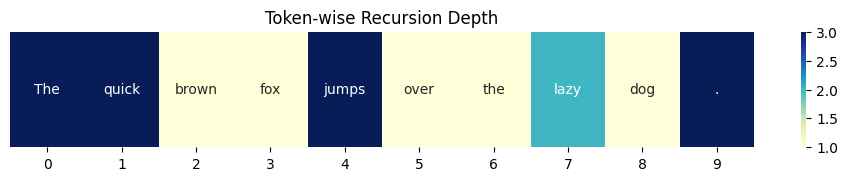

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_token_routing(tokens, depths):
    plt.figure(figsize=(12, 1.5))
    sns.heatmap([depths], annot=[tokens], fmt='', cmap="YlGnBu", cbar=True)
    plt.title("Token-wise Recursion Depth")
    plt.yticks([])  # Remove y-axis
    plt.show()

plot_token_routing(tokens, depth_values)

In [49]:
import torch

def compute_token_layer_map(routing_depths, max_depth):
    """
    routing_depths: Tensor [seq_len] or [1, seq_len] — per-token depth
    max_depth: int — maximum recursion depth (N_r)

    Returns:
        Tensor of shape [max_depth, seq_len], where
        M[r][t] = 1 if token t was active at recursion step r+1
    """
    if routing_depths.dim() == 2:
        routing_depths = routing_depths[0]  # Take batch[0] if needed

    seq_len = routing_depths.shape[0]
    map_matrix = torch.zeros((max_depth, seq_len), dtype=torch.int)

    for r in range(1, max_depth + 1):
        active = (routing_depths >= r)  # shape: [seq_len]
        map_matrix[r - 1] = active.int()  # row r-1 = 1 if token is active

    return map_matrix


In [50]:
map_matrix = compute_token_layer_map(depths, config["recursion_depth"])
print(map_matrix.shape)  # [N_r, seq_len]
print(map_matrix)

torch.Size([3, 10])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 1]], dtype=torch.int32)


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from matplotlib.patches import Patch

def plot_token_layer_map(map_matrix, tokens, max_tokens=40):
    """
    map_matrix: [num_layers, seq_len]
    tokens: list of strings (tokens)
    max_tokens: how many tokens to show (for readability)
    """
    num_layers, seq_len = map_matrix.shape

    # Trim if too long
    if seq_len > max_tokens:
        map_matrix = map_matrix[:, :max_tokens]
        tokens = tokens[:max_tokens]

    # Custom colormap: 1 → dark gray (computed), 0 → light gray (skipped)
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(["#eeeeee", "#444444"])

    colors = ["#eeeeee", "#444444"]
    labels = ['Not Computed', 'Computed']

    legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

    plt.figure(figsize=(1 + 0.35 * len(tokens), 1 + 0.5 * num_layers))
    ax = sns.heatmap(
        map_matrix.numpy(),
        cmap=cmap,
        linewidths=0.5,
        linecolor='black',
        cbar=False,
        xticklabels=tokens,
        yticklabels=[f"R{r+1}" for r in range(num_layers)],
        square=False
    )

    ax.set_xlabel("Token Position")
    ax.set_ylabel("Recursion Step")
    ax.set_xticklabels(tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

    plt.title("Token-wise Recursion Map", fontsize=12)
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.tight_layout()
    plt.show()


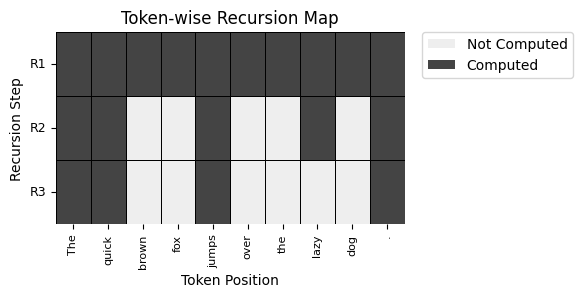

In [52]:
plot_token_layer_map(map_matrix, tokens)